In [3]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
import pytorch_lightning as pl

In [4]:
config = helper.Config("./simulations",default_config_file="./default_config_cifar10.ini")
if config.INFO["fix_random_seed"]:
    pl.seed_everything(137) # To be reproducable

Seed set to 137


Loading default settings...
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_node = 8
precision = 16-mixed
fix_random_seed = True

[DATA]
dataset = CIFAR10
n_views = 8
augmentations = ['RandomResizeCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
crop_size = 32
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 1
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8

[SSL]
backbone = resnet18
backbone_out_dim = 2048
use_projection_header = True
proj_out_dim = 256
optimizer = LARS
lr = 0.1
lr_scale = linear
momentum = 0.99
weight_decay = 0.1
lars_eta = 0.1
loss_function = EllipsoidPackingLoss
lw0 = 1.0
lw1 = 1.0
lw2 = 1.0
rs = 3.0
warmup_epochs = 1
n_epochs = 2
batch_size = 64
save_every_n_epochs = 1

[LC]
output_dim = 10
optimizer = SGD
use_batch_norm = True
lr = 0.01
lr_scale = linear
weight_decay = 0.0001
momentum = 0.99
loss_function = Cr

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


703


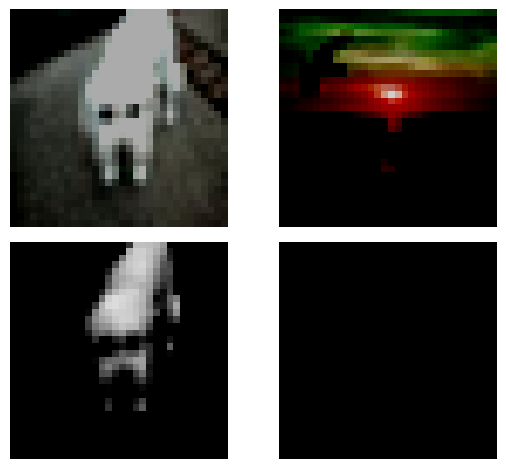

In [3]:
# for multi-gpu trainning, effective batch size = batch_size*num_gpus
ssl_batch_size = config.SSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
lc_batch_size = config.LC["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])

ssl_train_loader,lc_train_loader,test_loader,val_loader = data_utils.get_dataloader(config.DATA,ssl_batch_size,lc_batch_size,config.INFO["cpus_per_node"]*config.INFO["num_nodes"])
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))

In [4]:
if config.SSL["lr_scale"] == "linear":
    ssl_lr = config.SSL["lr"]*config.SSL["batch_size"]/256.0 # lr ~ 0.1
elif config.SSL["lr_scale"] == "sqrt":
    ssl_lr = config.SSL["lr"]*math.sqrt(config.SSL["batch_size"]) # lr ~ 0.05
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  backbone_out_dim = config.SSL["backbone_out_dim"],
                                  prune = prune_backbone,
                                  use_projection_header=config.SSL["use_projection_header"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = ssl_lr,
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"])

In [5]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, 
                                        train_loader = ssl_train_loader,
                                        max_epochs=config.SSL["n_epochs"],
                                        every_n_epochs = config.SSL["save_every_n_epochs"],
                                        precision = config.INFO["precision"],
                                        checkpoint_path=ssl_dir)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/guanming/Documents/clap/simulations/ssl exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | backbone | BackboneNet | 12.7 M | train
-------------------------------------------------
12.7 M    Trainable params
0        

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
`Trainer.fit` stopped: `max_epochs=2` reached.


In [6]:
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
ssl_model.backbone.remove_projection_header()
if config.LC["lr_scale"] == "linear":
    lc_lr = config.LC["lr"]*config.LC["batch_size"]/256.0 # lr ~ 0.1
elif config.LC["lr_scale"] == "sqrt":
    lc_lr = config.LC["lr"]*math.sqrt(config.LC["batch_size"]) # lr ~ 0.05
lc_model = lightning_models.LinearClassification(
                 in_dim = config.SSL["backbone_out_dim"],
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 lr = lc_lr, 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
lc_model.set_backbone(ssl_model.backbone)
lc_model = lightning_models.train_lc(ssl_model = ssl_model, 
            ssl_ckpt_path = ssl_dir,
            linear_model = lc_model,
            train_loader = lc_train_loader,
            val_loader = val_loader,
            test_loader = test_loader,
            max_epochs = config.LC["n_epochs"],
            precision = config.INFO["precision"],
            checkpoint_path = lc_dir,
            mode = config.LC["training_mode"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | linear_net | BnLinearNet | 24.6 K | train
1 | backbone   | BackboneNet | 12.2 M | train
---------------------------------------------------
24.6 K    Trainable params
12.2 M    Non-trainable params
12.2 M    Total params
48.976    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...
/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     batch_test_acc1        0.10376602411270142
     batch_test_acc5        0.5136218070983887
     batch_test_loss         2.308361053466797
        test_acc1           0.10376602411270142
        test_acc5           0.5136218070983887
        test_loss            2.308361053466797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
